# Sentiment Analysis with Deep Learning using BERT

## Exploratory Data Analysis and Preprocessing

In [2]:
pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/3e/b9/256ab23c859cbcd7d6fb7cb46417a07eac817881a0a68df8ea0c18f45221/torch-2.2.1-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/f9/de/dc04a3ea60b22624b51c703a84bbe0184abcd1d0b9bc8074b5d6b7ab90bb/typing_extensions-4.10.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 2.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
smile_df = pd.read_csv('smile-annotations-final.csv', names = ['id','text','category'])
smile_df.set_index('id', inplace = True)

In [5]:
smile_df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [6]:
#Look at the first tweet
smile_df.text.iloc[0]

'@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap'

In [7]:
smile_df['category'].value_counts()

category
nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: count, dtype: int64

In [8]:
smile_df.shape

(3085, 2)

In [9]:
smile_df = smile_df[~smile_df.category.str.contains('\|')]

In [10]:
smile_df = smile_df[smile_df.category != 'nocode']

In [11]:
smile_df.category.value_counts()

category
happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: count, dtype: int64

In [12]:
labels = smile_df.category.unique()
labels

array(['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise'],
      dtype=object)

In [13]:
label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index

In [14]:
label_dict

{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [15]:
smile_df['labels'] = smile_df.category.replace(label_dict)
smile_df.head(10)

,text,category,labels
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0
614499696015503361,Lucky @FitzMuseum_UK! Good luck @MirandaStearn...,happy,0
613601881441570816,Yr 9 art students are off to the @britishmuseu...,happy,0
613696526297210880,@RAMMuseum Please vote for us as @sainsbury #s...,not-relevant,1
610746718641102848,#AskTheGallery Have you got plans to privatise...,not-relevant,1


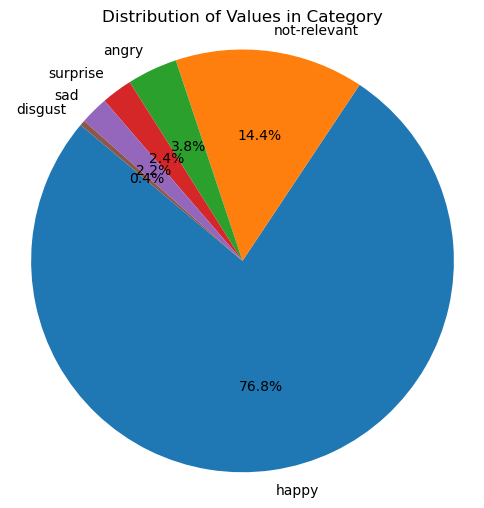

In [26]:
import matplotlib.pyplot as plt
value_counts = smile_df['category'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Values in Category')
plt.show()

## Training/Validation Split

In [27]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
smile_df.index.values,
smile_df.labels.values,
test_size = 0.15,
random_state = 17,
stratify = smile_df.labels.values)

In [32]:
smile_df['data_type'] = ['not_set']*smile_df.shape[0]
smile_df.head()

,text,category,labels,data_type
id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,not_set
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,not_set
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,not_set
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,not_set
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,not_set


In [33]:
smile_df.loc[X_train , 'data_type'] = 'train'
smile_df.loc[X_val , 'data_type'] = 'val'

In [34]:
smile_df.groupby(['category','labels','data_type']).count()

text
category     labels data_type      
angry        2      train        48
                    val           9
disgust      3      train         5
                    val           1
happy        0      train       966
                    val         171
not-relevant 1      train       182
                    val          32
sad          4      train        27
                    val           5
surprise     5      train        30
                    val           5

## Loading Tokenizer and Encoding our Data

In [35]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [36]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
do_lower_case = True)

In [37]:
encoded_data_train = tokenizer.batch_encode_plus(
smile_df[smile_df.data_type == 'train'].text.values,
add_special_tokens = True,
return_attention_mask = True,
pad_to_max_length = True,
max_length = 256,
return_tensors = 'pt')

encoded_data_val = tokenizer.batch_encode_plus(
smile_df[smile_df.data_type == 'val'].text.values,
add_special_tokens = True,
return_attention_mask = True,
pad_to_max_length = True,
max_length = 256,
return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/vidushibhargava/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [38]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(smile_df[smile_df.data_type == 'train'].labels.values)

In [39]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(smile_df[smile_df.data_type == 'val'].labels.values)

In [40]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)


In [41]:
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)


In [42]:
len(dataset_train)

1258

In [43]:
len(dataset_val)

223

##  Setting up BERT Pretrained Model

In [44]:
from transformers import BertForSequenceClassification

/Users/vidushibhargava/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [45]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                      num_labels = len(label_dict),
                                     output_attentions = False,
                                     output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Creating Data Loaders

In [46]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [47]:
batch_size = 4

dataloader_train = DataLoader(
dataset_train,
sampler = RandomSampler(dataset_train),
    batch_size = batch_size)

dataloader_val = DataLoader(
dataset_val,
sampler = RandomSampler(dataset_val),
    batch_size = 32)

## Setting Up Optimizer and Scheduler

In [48]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [49]:
optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8)

/Users/vidushibhargava/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [50]:
epochs = 10
scheduler = get_linear_schedule_with_warmup(
optimizer,
num_warmup_steps = 0,
num_training_steps = len(dataloader_train)*epochs)

## Defining our Performance Metrics

In [51]:
import numpy as np

In [52]:
from sklearn.metrics import f1_score

In [53]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [54]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.itmes()}
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    for label in no.unique(labels_flat):
        y_preds = pred_flat(labels_flat == labels)
        y_true = labels_flat(labels_flat == labels)
        print(f'Class: {label_dict_inverse[labels]}')
        print(f'Accuracy: {len(y_preds[y_preds == labels])}/{len(y_true)}\n')

## Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [55]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


In [57]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [61]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        # Convert logits to class predictions
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())

        # Convert true labels to numpy array
        true_vals.extend(inputs['labels'].cpu().numpy())
    
    loss_val_avg = loss_val_total / len(dataloader_val) 
    
    return loss_val_avg, predictions, true_vals


In [62]:
import os

# Create the directory if it does not exist
directory = 'Models'
if not os.path.exists(directory):
    os.makedirs(directory)


In [64]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train,
                        desc = 'Epoch {:1d}'.format(epoch),
                       leave = False,
                       disable = False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask':batch[1],
            'labels':batch[2]
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
    torch.save(model.state_dict(),f'Models/BERT_ft_epoch{epoch}.model')
    tqdm.write('\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    #val_f1 = f1_score(predictions, true_vals)
    val_f1 = f1_score(predictions, true_vals, average='weighted')

    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'f1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.21975119949155858


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7358354926109314
f1 Score (weighted): 0.8941698484274397


Epoch 2:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.1560998708944738


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7566712541239602
f1 Score (weighted): 0.8574026480440985


Epoch 3:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.10898429737611127


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7374689153262547
f1 Score (weighted): 0.8780395935181773


Epoch 4:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.07004969982496861


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7395611128636769
f1 Score (weighted): 0.8636187335127753


Epoch 5:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.05033099715346618


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.767678039414542
f1 Score (weighted): 0.8860868731884225


Epoch 6:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.03720296746090291


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7910718790122441
f1 Score (weighted): 0.8881462949751358


Epoch 7:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.03064160270631195


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7868118967328753
f1 Score (weighted): 0.8824814816910305


Epoch 8:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.02974624425239329


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7843393023524966
f1 Score (weighted): 0.8824814816910305


Epoch 9:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.02851861600989535


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.785418587071555
f1 Score (weighted): 0.8824814816910305


Epoch 10:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.030435720230600545


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7861319056579045
f1 Score (weighted): 0.8824814816910305


## Loading and Evaluating our Model

In [65]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
# Load the trained model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# Specify the file path to the model's weights file
model_path = '/Users/vidushibhargava/Downloads/Models/BERT_ft_epoch10.model'  # Update with the correct file path

# Load the model's weights
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [94]:
# Define a function to calculate accuracy
def compute_accuracy(predictions, true_labels):
    # Convert predictions and true labels to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Calculate the number of correct predictions
    correct_predictions = np.sum(predictions == true_labels)
    
    # Calculate the total number of predictions
    total_predictions = len(true_labels)
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    
    return accuracy

# Evaluate the model on the validation set
val_loss, predictions, true_vals = evaluate(dataloader_val)

# Calculate accuracy
accuracy = compute_accuracy(predictions, true_vals)

  0%|          | 0/7 [00:00<?, ?it/s]